<a href="https://colab.research.google.com/github/ericiortega/ids705-phishing-detection/blob/main/notebooks/1_baseline_vs_other_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np

In [5]:
df = pd.read_csv(
    "https://raw.githubusercontent.com/ericiortega/ids705-phishing-detection/main/data/cleaning/2_cleaned_data.csv"
)
df

,sender,receiver,clean_text,urls,label
0,Tomas Jacobs <RickyAmes@aol.com>,the00@speedy.uwaterloo.ca,"Generic Cialis, branded quality@ \n\n\n\n\n\n...",0,1
1,Yan Morin <yan.morin@savoirfairelinux.com>,debian-mirrors@lists.debian.org,"Typo in /debian/README Hi, i've just updated f...",1,0
2,Sheila Crenshaw <7stocknews@tractionmarketing....,the00@plg.uwaterloo.ca,authentic viagra Mega authenticV I A G R A ...,1,1
3,Stormy Dempsey <vqucsmdfgvsg@ruraltek.com>,opt4@speedy.uwaterloo.ca,"Nice talking with ya \nHey Billy, \n\nit was r...",1,1
4,"""Christi T. Jernigan"" <dcube@totalink.net>",ktwarwic@speedy.uwaterloo.ca,or trembling; stomach cramps; trouble in sleep...,0,1
...,...,...,...,...,...
52708,SCC <Gerry.Rossi4360@kinki-kids.com>,Deficient <deficient@flax9.uwaterloo.ca>,Job: just for you. \n\n\n\nWhile we may ...,1,1
52709,Sydney Car Centre <Merrill8783@168city.com>,Gnitpick <gnitpick@flax9.uwaterloo.ca>,the reply for your request for a job place [le...,1,1
52710,Philippe Grosjean <phgrosjean@sciviews.org>,Duncan Murdoch <murdoch@stats.uwo.ca>,"Re: [R] Me again, about the horrible documenta...",1,0
52711,Bernhard Wellhöfer <Bernhard.Wellhoefer@gaia-g...,r-help@stat.math.ethz.ch,"Re: [R] RODBC problem Hello,\n\nas I wrote I c...",1,0


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


✅ Accuracy: 0.9966802617850706

📋 Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00      4926
           1       1.00      1.00      1.00      5617

    accuracy                           1.00     10543
   macro avg       1.00      1.00      1.00     10543
weighted avg       1.00      1.00      1.00     10543



<Figure size 600x500 with 0 Axes>

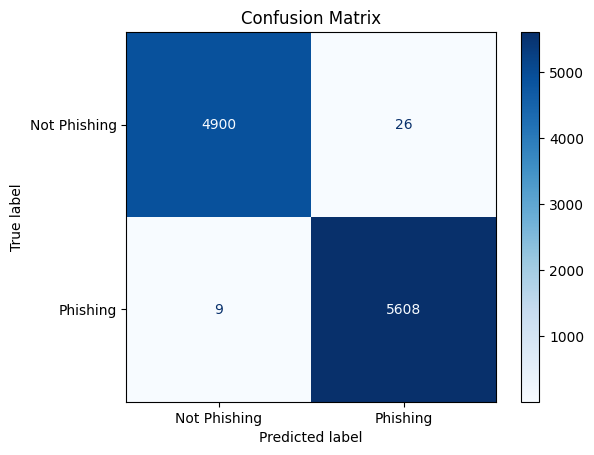

In [11]:
import pandas as pd
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
import matplotlib.pyplot as plt

# Download NLTK resources
nltk.download("stopwords")
nltk.download("wordnet")

# === Step 1: Prepare data ===
# Make sure all text fields are strings
for col in ["clean_text", "sender", "receiver"]:
    df[col] = df[col].fillna("unknown").replace("", "unknown").astype(str)

# === Step 2: Select features and label ===
X = df[["clean_text", "sender", "receiver", "urls"]]  # urls stays as binary
y = df["label"]

# === Step 3: Build preprocessing pipeline ===
preprocessor = ColumnTransformer(
    transformers=[
        ("text", TfidfVectorizer(max_features=1000), "clean_text"),
        ("sender", TfidfVectorizer(max_features=100), "sender"),
        ("receiver", TfidfVectorizer(max_features=100), "receiver"),
    ],
    remainder="passthrough"  # keep 'urls' as is (numeric)
)

# === Step 4: Build and train the model ===
model = make_pipeline(preprocessor, LogisticRegression(max_iter=2000))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model.fit(X_train, y_train)

# === Step 5: Evaluate ===
y_pred = model.predict(X_test)
print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("\n📋 Classification Report:\n", classification_report(y_test, y_pred))

# === Step 6: Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Phishing", "Phishing"])

plt.figure(figsize=(6, 5))
disp.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()


# Naive

In [12]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

nb_model = Pipeline(
    [("tfidf", TfidfVectorizer(max_features=1000)), ("clf", MultinomialNB())]
)

nb_model.fit(X_train["clean_text"], y_train)
y_pred_nb = nb_model.predict(X_test["clean_text"])

print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Naive Bayes Report:\n", classification_report(y_test, y_pred_nb))

Naive Bayes Accuracy: 0.9539979133074078
Naive Bayes Report:
               precision    recall  f1-score   support

           0       0.96      0.94      0.95      4926
           1       0.95      0.97      0.96      5617

    accuracy                           0.95     10543
   macro avg       0.95      0.95      0.95     10543
weighted avg       0.95      0.95      0.95     10543



In [13]:
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=1000)
X_train_vec = vectorizer.fit_transform(X_train["clean_text"])
X_test_vec = vectorizer.transform(X_test["clean_text"])

# Train XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss")
xgb_model.fit(X_train_vec, y_train)
y_pred_xgb = xgb_model.predict(X_test_vec)

print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("XGBoost Report:\n", classification_report(y_test, y_pred_xgb))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:03:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.9929811249170065
XGBoost Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99      4926
           1       0.99      1.00      0.99      5617

    accuracy                           0.99     10543
   macro avg       0.99      0.99      0.99     10543
weighted avg       0.99      0.99      0.99     10543



In [14]:
%pip install --upgrade transformers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 77.2 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.51.1
    Uninstalling transformers-4.51.1:
      Successfully uninstalled transformers-4.51.1


In [15]:
%pip install -U "accelerate>=0.26.0"


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.7/354.7 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 66.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [16]:
from transformers import (
    BertTokenizerFast,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments,
)
from datasets import Dataset
import torch
from sklearn.metrics import accuracy_score, classification_report

# Prepare the data
train_texts = X_train["clean_text"].tolist()
test_texts = X_test["clean_text"].tolist()

tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

train_dataset = Dataset.from_dict({**train_encodings, "label": y_train.tolist()})
test_dataset = Dataset.from_dict({**test_encodings, "label": y_test.tolist()})

# Load BERT model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# Training arguments (no evaluation_strategy or save_strategy)
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    logging_dir="./logs",
    logging_steps=10,
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# Train
trainer.train()

# Predict
preds = trainer.predict(test_dataset)
y_pred_bert = preds.predictions.argmax(-1)

# Evaluate
print("BERT Accuracy:", accuracy_score(y_test, y_pred_bert))
print("BERT Report:\n", classification_report(y_test, y_pred_bert))

KeyboardInterrupt: 